In [57]:
%pylab inline
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
#np.set_printoptions(suppress=True)
np.set_printoptions(edgeitems=25, linewidth=100000)

Populating the interactive namespace from numpy and matplotlib


In [4]:
# load the mnist dataset

def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [112]:
#model
import torch
import torch.nn as nn
import torch.nn.functional as F

class pyNet(torch.nn.Module):
    def __init__(self):
        super(pyNet, self).__init__()
        self.l1 = nn.Linear(784,128)
        self.l2 = nn.Linear(128, 10)
        self.sm = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        x = self.sm(x)
        return x


loss is 0.17 and acc is 0.95: 100%|██████████| 1000/1000 [00:12<00:00, 80.77it/s]


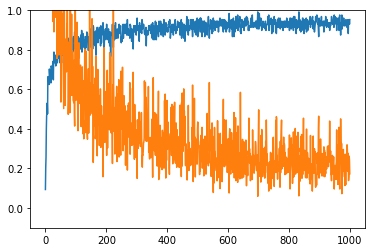

In [113]:
#training
model = pyNet()
batch_size = 128
loss_func = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
losses, accs = [],[]
for i in (t := trange(1000)):
    samp = np.random.randint(0,X_train.shape[0], size=(batch_size))
    X = torch.tensor(X_train[samp].reshape((-1,28*28))).float()
    Y = torch.tensor(Y_train[samp]).long()
    model.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=1)
    acc = (cat==Y).float().mean()
    loss = loss_func(out, Y)
    loss.backward()
    optim.step()
    losses.append(loss.item())
    accs.append(acc)
    t.set_description(f'loss is {loss.item():.2f} and acc is {acc:.2f}')
    #print(loss)
plt.ylim(-0.1,1)
plt.plot(accs)
plt.plot(losses)
plt.show()

In [111]:
#evaluation
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1,28*28))).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean() 

0.9307

In [44]:
#init weight matrices
l1 = np.zeros((784, 128), dtype=np.float32)
l2 = np.zeros((128, 10), dtype=np.float32)


In [45]:
# copy pytorch weights
l1[:] = model.l1.weight.detach().numpy().transpose()
l2[:] = model.l2.weight.detach().numpy().transpose()

In [84]:
# numpy forward pass
def forward(x):
    x = x.dot(l1)
    x = np.maximum(0,x)
    x = x.dot(l2)
    return x
Y_test_preds_out = forward(X_test.reshape((-1,28*28)))
Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
(Y_test == Y_test_preds).mean()
Y_test_preds[0]

7

In [114]:
#training in numpy
# backward pass

out = np.zeros(10)
out[2] = 1
out = torch.tensor(out)

#derivative of logsoftmax

gin = torch.tensor(Y_test_preds_out[1], requires_grad=True)
gout = torch.nn.functional.log_softmax(gin, dim=0)
loss = (-out*gout).mean()
loss.backward()
dsm = gin.grad

#derivative of l2

print(dsm)

tensor([ 1.7686e-08,  6.8838e-13, -2.6971e-06,  1.1616e-07,  2.9069e-18,
         1.9532e-06,  5.9875e-07,  4.0768e-20,  2.3786e-09,  4.0840e-23])


In [89]:
# training in numpy
ret = -Y_test_preds_out[range(Y_test_preds_out.shape[0]),Y_test] + np.log(np.exp(Y_test_preds_out).sum(axis=1))

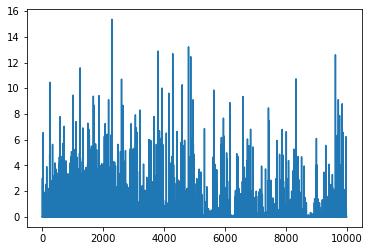

In [90]:
plt.plot(ret)

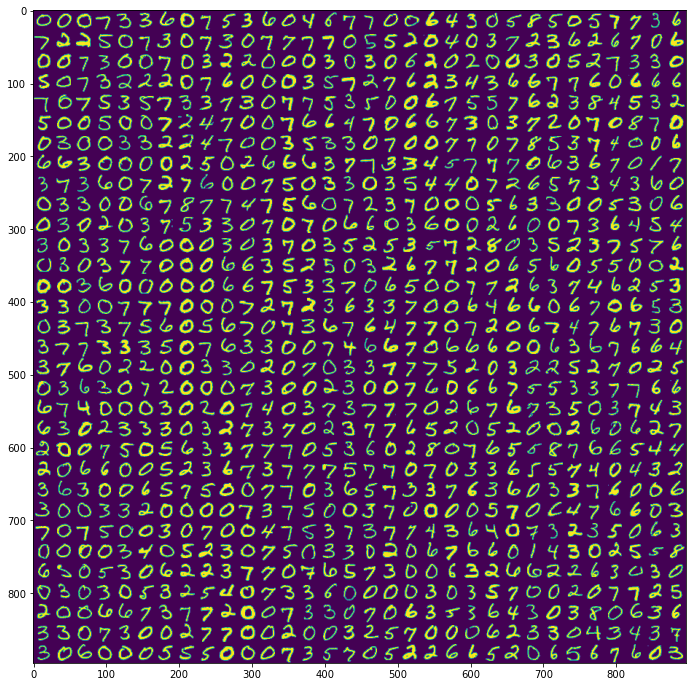

In [109]:
G = 32
grid = sorted(list(zip(ret, range(ret.shape[0]))), reverse=False)[0:G*G]
X_bad = X_test[[x[1] for x in grid]]
plt.figure(figsize=(12,12))
plt.imshow(np.concatenate(X_bad.reshape((G,G*28,28)), axis=1))